# Automatic and Interactive Segment Anything Model in Medical Images 

In [1]:
%matplotlib widget
from segment_anything import sam_model_registry
from os.path import join, isfile, basename
from os import getcwd
from matplotlib import pyplot as plt
from ipywidgets import interact, widgets, TwoByTwoLayout, HBox
from ai_sam.ai_sam import AISAM
from torch.nn import functional as F
import cv2
import torch
import numpy as np
import gc
import SimpleITK as sitk
import numpy as np
from matplotlib import pyplot as plt

## Define point prompt inference pipeline and GUI

The whole inference pipeline is the same as the bounding box-based version. The only difference is that the prompt encoder will accept point inputs.

In [2]:
def general_to_onehot(g_points):
    """
        assume the last two dimensions are spatial, h and w
        return the relative position of the point [0,1]
    """
    g_point_size = g_points.shape[-2:]
    g_points = g_points.flatten(-2).argmax(-1)
    points_x = (g_points % g_point_size[1]) / g_point_size[1]
    points_y = (g_points // g_point_size[0]) / g_point_size[0]
    points = torch.stack([points_x,points_y],dim=-1)
    return points

class PointPromptDemo:
    def __init__(self, model):
        self.model = model
        self.model.eval()
        self.image = None
        self.image_embeddings = None
        self.img_size = None
        self.labels = None
        self.points = None
        self.auto_points = None
        

    def show_mask(self, mask, ax, random_color=False, alpha=0.35):
        if random_color:
            color = np.concatenate([np.random.random(3), np.array([alpha])], axis=0)
        else:
            color = np.array([251/255, 252/255, 30/255, alpha])
        h, w = mask.shape[-2:]
        mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
        ax.imshow(mask_image)

    @torch.no_grad()
    def infer(self, points,labels):
        coords_1024 = np.array([points]) * 1024 / np.array(self.img_size)
        coords_torch = torch.tensor(coords_1024, dtype=torch.float32).to(self.model.device)
        labels_torch = torch.tensor([labels], dtype=torch.long).to(self.model.device)
        point_prompt = (coords_torch, labels_torch)

        sparse_embeddings, dense_embeddings = self.model.prompt_encoder(
            auto_prompt=None,
            points = point_prompt,
            boxes = None,
            masks = None,
        )
        low_res_logits, _ = self.model.mask_decoder(
            image_embeddings=self.image_embeddings, # (B, 256, 64, 64)
            image_pe=self.model.prompt_encoder.get_dense_pe(), # (1, 256, 64, 64)
            sparse_prompt_embeddings=sparse_embeddings, # (B, 2, 256)
            dense_prompt_embeddings=dense_embeddings, # (B, 256, 64, 64)
            multimask_output=False,
        )

        low_res_probs = torch.sigmoid(low_res_logits)  # (1, 1, 256, 256)
        low_res_pred = F.interpolate(
            low_res_probs,
            size = self.img_size,
            mode = 'bilinear',
            align_corners = False
        )
        low_res_pred = low_res_pred.detach().cpu().numpy().squeeze()

        seg = np.uint8(low_res_pred > 0.5)

        return seg

    def show(self, fig_size=5, alpha=0.95, scatter_size=10):

        assert self.image is not None, "Please set image first."
        
        radio_buttons = widgets.RadioButtons(
                        options=['foreground','background'],
                        value='foreground', # Defaults to 'forground'
                    #    layout={'width': 'max-content'}, # If the items' names are long
                        description='point type:',
                        disabled=False
                    )
        
        radio_point_mode_buttons = widgets.RadioButtons(
                        options=['add','remove'],
                        value='add', # Defaults to 'forground'
                    #    layout={'width': 'max-content'}, # If the items' names are long
                        description='point mode:',
                        disabled=False
                    )
        radio_class_buttons = widgets.RadioButtons(
                        options=[i for i in range(self.model.num_classes)],
                        value=0, # Defaults to 'forground'
                       layout={'width': 'max-content'}, # If the items' names are long
                        description='class:',
                        disabled=False
                    )
        def on_value_change(change):
            with out:
                self.labels = []
                self.points = []
                if change['new']!=0:
                    for i, points in enumerate(self.auto_points):
                        if i==change['new']:
                            self.labels+=([1]*len(points))
                        else:
                            self.labels+=([0]*len(points))
                        self.points+=points
                seg = None
                if self.points is not None and len(self.points) > 0:
                    with torch.no_grad():
                        ## rescale x, y from canvas size to 1024 x 1024
                        seg = self.infer(self.points, self.labels)

                ax.clear()
                ax.imshow(self.image)
                ax.axis('off')
                if self.points is not None and len(self.points) > 0:
                    colors = [['blue','r'][i] for i in self.labels]
                    ax.scatter(np.array(self.points)[:,0], np.array(self.points)[:,1], c=colors, s=scatter_size)
                if seg is not None:
                    self.show_mask(seg, ax, random_color=False, alpha=alpha)
                gc.collect()

        radio_class_buttons.observe(on_value_change, names='value')
        clear_button = widgets.Button(description="clear")
        def __on_clear_button_clicked(b):
            ax.clear()
            ax.imshow(self.image)
            ax.axis('off')
            self.labels = None
            self.points = None
        clear_button.on_click(__on_clear_button_clicked)
        out = widgets.Output(layout={'border': '1px solid black'})
        display(out)
        top_panel = TwoByTwoLayout(top_left=radio_buttons,
               top_right=radio_point_mode_buttons,
               bottom_left=radio_class_buttons,
               bottom_right=clear_button)
        display(top_panel)
        
        seg = None
        fig, ax = plt.subplots(1, 1, figsize=(fig_size, fig_size))
        # fig.canvas.header_visible = False
        # fig.canvas.footer_visible = False
        # fig.canvas.toolbar_visible = False
        # fig.canvas.resizable = False

        plt.tight_layout()

        ax.imshow(self.image)
        ax.axis('off')
        
        def onclick(event):
            if event.inaxes == ax:
                
                with out:
                    x, y = float(event.xdata), float(event.ydata)
                    if self.labels is None: self.labels = []
                    if self.points is None: self.points = []
                    if radio_point_mode_buttons.value == 'add':
                        self.labels.append(1 if radio_buttons.value == 'foreground' else 0)
                        self.points.append([x,y])
                    else:
                        remove_index = self.find_closest_point([x,y])
                        if remove_index is not None:
                            self.labels.pop(remove_index)
                            self.points.pop(remove_index)
                    seg = None
                    if self.points is not None and len(self.points) > 0:
                        with torch.no_grad():
                            ## rescale x, y from canvas size to 1024 x 1024
                            seg = self.infer(self.points, self.labels)

                    ax.clear()
                    ax.imshow(self.image)
                    ax.axis('off')
                    if self.points is not None and len(self.points) > 0:
                        colors = [['blue','r'][i] for i in self.labels]
                        ax.scatter(np.array(self.points)[:,0], np.array(self.points)[:,1], c=colors, s=scatter_size)
                    if seg is not None:
                        self.show_mask(seg, ax, random_color=False, alpha=alpha)
                    gc.collect()

        fig.canvas.mpl_connect('button_press_event', onclick)
        plt.show()

        save_button = widgets.Button(description="save")
        def __on_save_button_clicked(b):
            plt.savefig("seg_result.png", bbox_inches='tight', pad_inches=0)
            if seg is not None:
                cv2.imwrite("seg.png", seg)
                print(f"Segmentation result saved to {getcwd()}")

        display(save_button)
        save_button.on_click(__on_save_button_clicked)
        
        
        
        
    def find_closest_point(self,point,radius=3):
        if len(self.points) == 0:
            return None
        points = np.array(self.points)
        point = np.array(point)
        # compute distance
        points = ((points - point)**2).sum(-1)**0.5
        if points.min() > radius:
            return None
        return points.argmin()
    
    def set_auto_points(self):
        with torch.no_grad():
            points_type = torch.cat([
                self.model.prompt_encoder.not_a_point_embed.weight,
                self.model.prompt_encoder.point_embeddings[0].weight,
                self.model.prompt_encoder.point_embeddings[1].weight,
                ]).detach()
            auto_prompt_list, class_features, final_attn_weight_list, feature_list, feature_with_pe_list = self.model.auto_prompt(
                image=self.image_embeddings.detach(), 
                image_pe=self.model.prompt_encoder.get_dense_pe().detach(), 
                points_type=points_type,
                hard=True,
                bbox_masks=None # [B,N_class,H,W]
            )
            # B x N_class x N_points x H x W -> B x N_class x N_points x 2
            auto_points = general_to_onehot(final_attn_weight_list).squeeze()
            self.auto_points = (auto_points.detach().cpu().numpy()*np.array(self.img_size)).tolist()
            
            
            

    def set_image(self, image):
        self.img_size = image.shape[:2]
        if len(image.shape) == 2:
            image = np.repeat(image[:,:,None], 3, -1)
        self.image = image
        image_preprocess = self.preprocess_image(self.image)
        with torch.no_grad():
            self.image_embeddings = self.model.image_encoder(image_preprocess)[0]
        self.set_auto_points()
        
    def preprocess_image(self, image):
        img_resize = cv2.resize(
            image,
            (1024, 1024),
            interpolation=cv2.INTER_LINEAR
        )
        
        pixel_mean = np.array([123.675/255., 116.28/255., 103.53/255.])
        pixel_std = np.array([58.395/255., 57.12/255., 57.375/255.])
        # torch.Tensor(pixel_mean).view(-1, 1, 1)
        # Resizing
        img_resize = img_resize  / 255.
        assert np.max(img_resize)<=1.0 and np.min(img_resize)>=0.0, 'image should be normalized to [0, 1]'
        img_resize = (img_resize - pixel_mean) / pixel_std
        # convert the shape to (3, H, W)
        img_tensor = torch.tensor(img_resize).float().permute(2, 0, 1).unsqueeze(0).to(self.model.device)

        return img_tensor
    

## Load trained model

In [11]:
ai_sam_ckpt_path = "../weights/AI-SAM-acdc-vit_h-20231029-1700-105/ai_sam_acdc_vit_h_lora.pth"
device = "cuda:0"
ai_sam_model = AISAM(
        num_classes=4,
        sam_checkpoint='../weights/sam_vit_h_4b8939.pth',
        sam_model='vit_h',
        num_class_tokens=16,
        num_points=4,
        use_classification_head=True,
        use_hard_points=True,
        use_lora = True
    ).to(device)
checkpoint = torch.load(ai_sam_ckpt_path, map_location=device)
ai_sam_model.load_state_dict(checkpoint["model"],strict=True)
ai_sam_model = ai_sam_model.to(device)
ai_sam_model.device = device
ai_sam_model.eval()
print('done!')

hard: True
done!


In [12]:
# load demo img data..
demo_file_png = './assets/acdc_case_002_volume_ED_1_img.png'
demo_file_png = cv2.imread(demo_file_png, cv2.IMREAD_COLOR)
demo_file_png = cv2.cvtColor(demo_file_png, cv2.COLOR_BGR2RGB)
demo_file_png = cv2.resize(demo_file_png, (1024, 1024))

Output(layout=Layout(border_bottom='1px solid black', border_left='1px solid black', border_right='1px solid b…

TwoByTwoLayout(children=(RadioButtons(description='point type:', layout=Layout(grid_area='top-left'), options=…

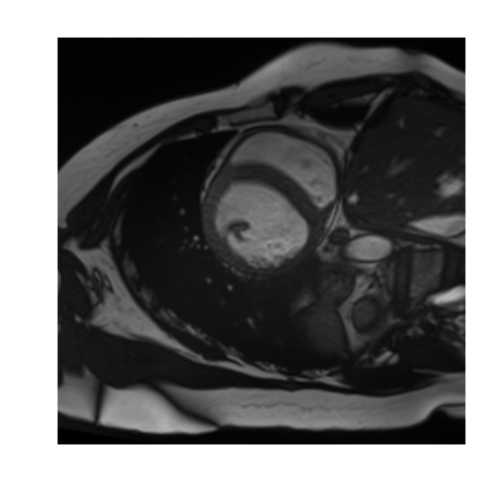

Button(description='save', style=ButtonStyle())

In [13]:
point_prompt_demo = PointPromptDemo(ai_sam_model)
point_prompt_demo.set_image(demo_file_png)
point_prompt_demo.show()

## Closing remarks

The implementation of the current AI-SAM mainly focus on the defined classes instead of open-vocabulary; introducing points for the undefined classes will not produce good segmentation masks. However, it is possible to expand the class list by training on a larger dataset.